# Heart Disease Prediction using K Nearest Neighbours

## Imports

In [115]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import  OneHotEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Constants

In [116]:
FOLDER = "Datasets/"
heart = 'heart.csv'

## Import Data

In [117]:
df = pd.read_csv(os.path.join(FOLDER,heart))

## Data Exploration

In [118]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [119]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [121]:
df['Age'].count()

918

<p>Here we see that the dataset is slightly biased towards HeartDisease. This is something that we must consider when finetuning our model.</p>

In [122]:
df["HeartDisease"].value_counts()/df['HeartDisease'].count()

HeartDisease
1    0.553377
0    0.446623
Name: count, dtype: float64

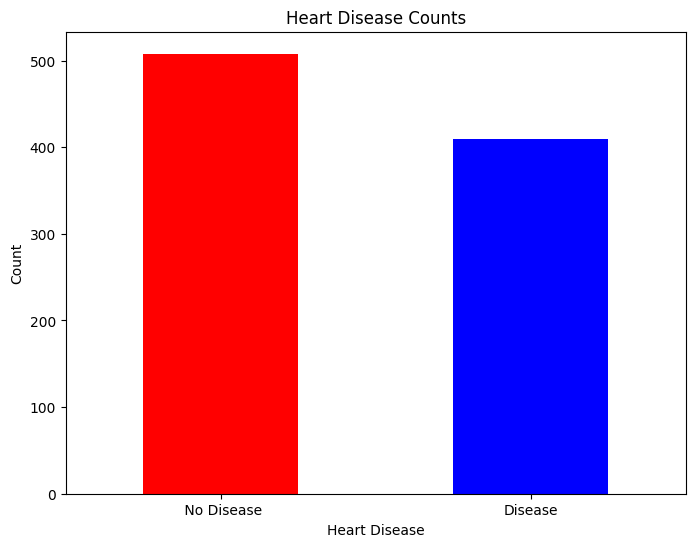

In [123]:
# Plotting
plt.figure(figsize=(8, 6))
df['HeartDisease'].value_counts().plot(kind='bar', color=['red', 'blue'])
plt.title('Heart Disease Counts')
plt.xlabel('Heart Disease')
plt.ylabel('Count')
plt.xticks([1, 0], ['Disease', ' No Disease'], rotation=0)
plt.show()

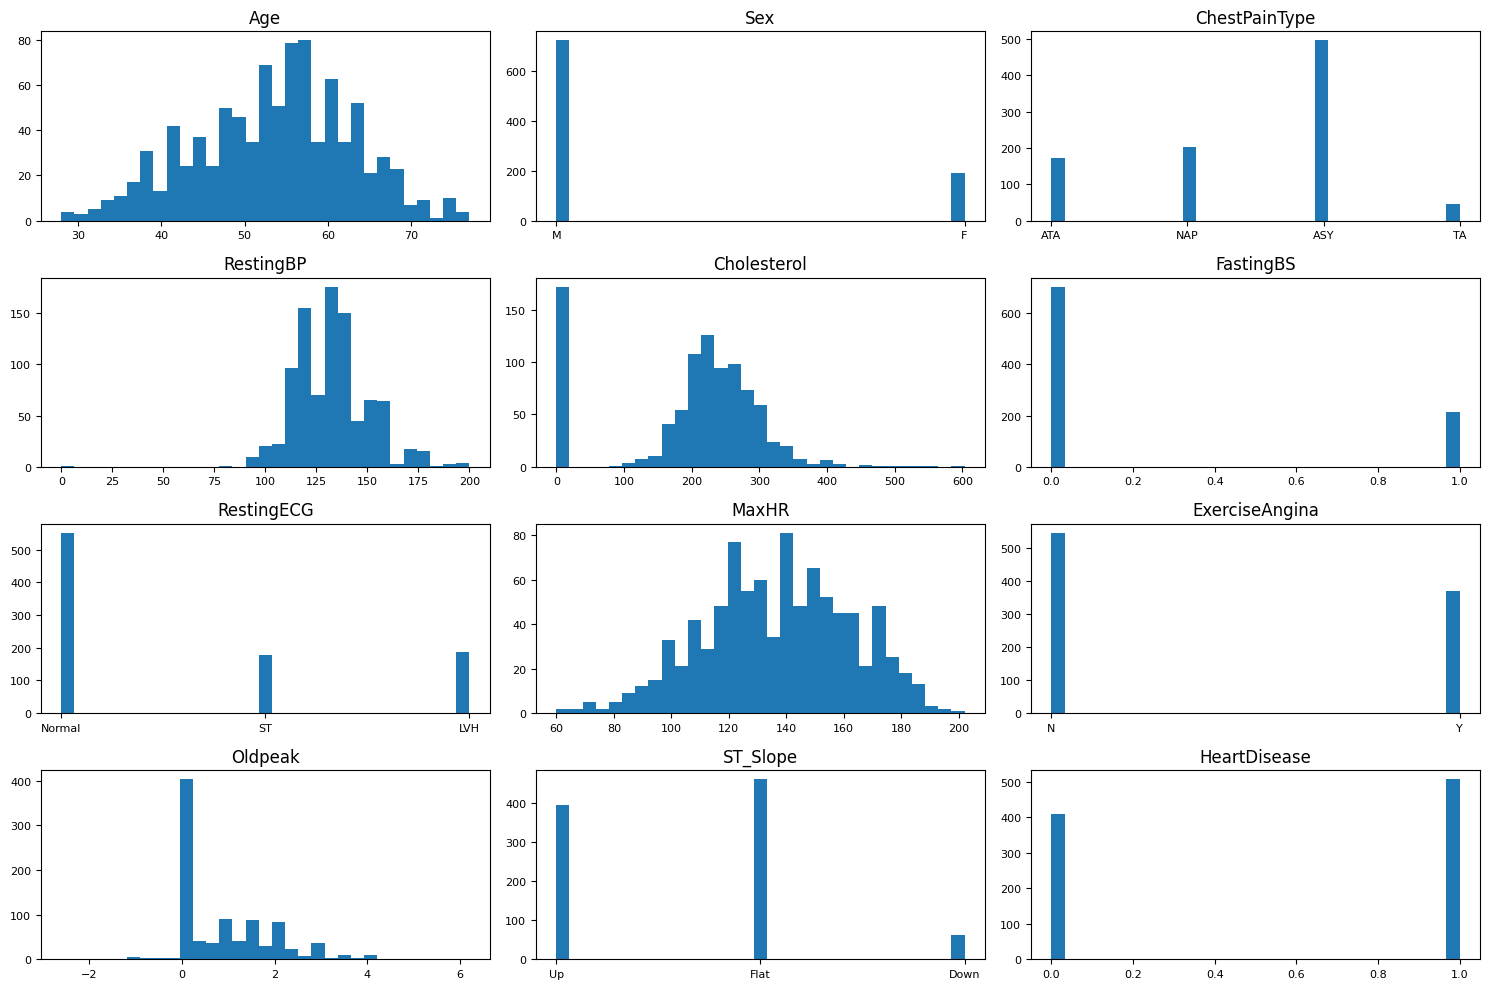

In [124]:
num_rows = 4
num_cols = 3
total_plots = num_rows * num_cols

plt.figure(figsize=(15, 10))

for i, col in enumerate(df.columns):
    plt.subplot(num_rows, num_cols, i+1)
    plt.hist(df[col], bins='sqrt')
    plt.title(col, fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

# Adjust layout
plt.tight_layout()

plt.show()

In [125]:
# Selecting numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Calculating range for each numerical column
range_values = df[numerical_cols].max() - df[numerical_cols].min()

# Calculating standard deviation for each numerical column
std_deviation = df[numerical_cols].std()

print("Range of values for each numerical feature:")
print(range_values)
print("\nStandard deviation of each numerical feature:")
print(std_deviation)

Range of values for each numerical feature:
Age              49.0
RestingBP       200.0
Cholesterol     603.0
FastingBS         1.0
MaxHR           142.0
Oldpeak           8.8
HeartDisease      1.0
dtype: float64

Standard deviation of each numerical feature:
Age               9.432617
RestingBP        18.514154
Cholesterol     109.384145
FastingBS         0.423046
MaxHR            25.460334
Oldpeak           1.066570
HeartDisease      0.497414
dtype: float64


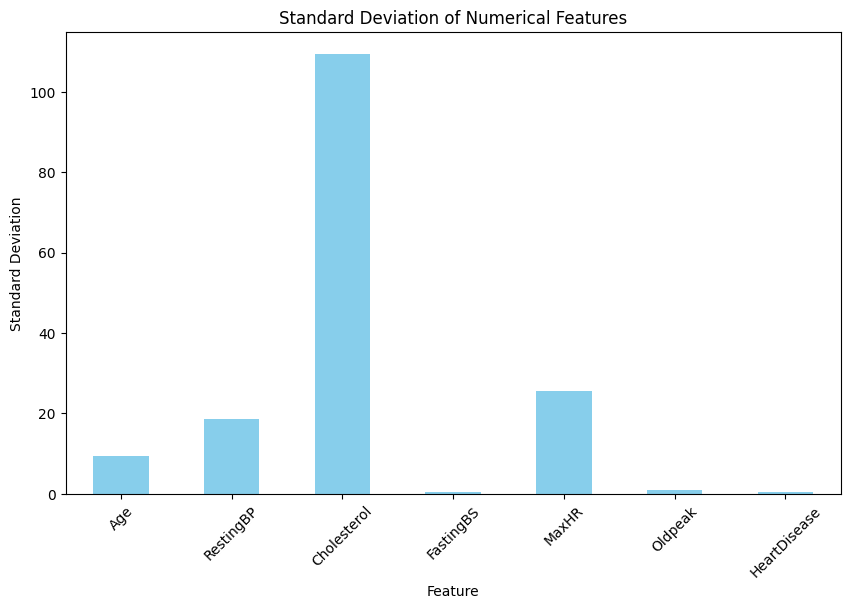

In [126]:
# Plotting the standard deviation values
plt.figure(figsize=(10, 6))
std_deviation.plot(kind='bar', color='skyblue')
plt.title('Standard Deviation of Numerical Features')
plt.xlabel('Feature')
plt.ylabel('Standard Deviation')
plt.xticks(rotation=45)
plt.show()

In [127]:
numerical_cols

Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'HeartDisease'],
      dtype='object')

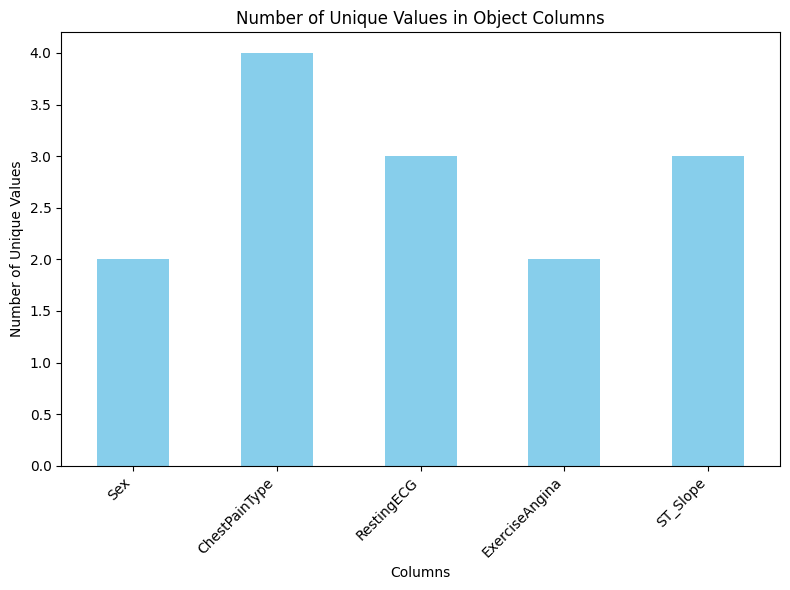

In [128]:
# Selecting object columns
object_cols = df.select_dtypes(include=['object']).columns

# Counting unique values in each object column
unique_counts = df[object_cols].nunique()

# Plotting
plt.figure(figsize=(8, 6))
unique_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Unique Values in Object Columns')
plt.xlabel('Columns')
plt.ylabel('Number of Unique Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Data Preprocessing

Check for missing values. None found for any variable

In [129]:
df[df.isnull().any(axis=1)].count()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Seperate target and features

In [130]:
X = df.drop(['HeartDisease'], axis=1)
y = df['HeartDisease']

<p> Identify categorical variables </p>

In [131]:
print(object_cols)

Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')


Perform one hot encoding on categorical variables

In [132]:
one = OneHotEncoder()
column_trans = make_column_transformer(
    (one,['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']),  
    remainder='passthrough'
)

In [133]:
X = column_trans.fit_transform(X)

In [134]:
y

0      0
1      1
2      0
3      1
4      0
      ..
913    1
914    1
915    1
916    1
917    0
Name: HeartDisease, Length: 918, dtype: int64

Create the training and test sets

In [135]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Model Creation

### Model 1

First attempt to include all features and an arbitary k value = 3

In [136]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [137]:
y_test

306    1
711    0
298    1
466    1
253    0
      ..
49     1
456    1
342    1
907    1
116    1
Name: HeartDisease, Length: 276, dtype: int64

In [138]:
y_pred = knn.predict(X_test)

A rather poor first attempt with accuracy of 65%. More finetuning is needed here

In [139]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.59      0.58      0.58       113
           1       0.71      0.72      0.71       163

    accuracy                           0.66       276
   macro avg       0.65      0.65      0.65       276
weighted avg       0.66      0.66      0.66       276



### Model 2

Next model we will tune the n_neighbours hyperparameter using cross validation

In [140]:
parameters = {"n_neighbors": range(1, 50)}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train, y_train)
gridsearch.best_params_

{'n_neighbors': 35}

With our second attempt, we increase from 65 to 72. A sizeable increase but still not very good. Next step is to try some feature engineering since the results so far have been less than ideal. This makes me suspect that our feature vector needs adjustment.

In [141]:
y_pred = gridsearch.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.65      0.73      0.68       113
           1       0.79      0.72      0.76       163

    accuracy                           0.72       276
   macro avg       0.72      0.72      0.72       276
weighted avg       0.73      0.72      0.73       276



### Feature Engineering

We will first check whether some features do not have any bearing on heart disease causation. Reviewing results all features seem to have some correlation.

In [142]:
# Calculating correlation matrix
df[numerical_cols].corr().round(2).style.background_gradient(cmap="viridis")

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
Age,1.000000,0.250000,-0.100000,0.200000,-0.380000,0.260000,0.280000
RestingBP,0.250000,1.000000,0.100000,0.070000,-0.110000,0.160000,0.110000
Cholesterol,-0.100000,0.100000,1.000000,-0.260000,0.240000,0.050000,-0.230000
FastingBS,0.200000,0.070000,-0.260000,1.000000,-0.130000,0.050000,0.270000
MaxHR,-0.380000,-0.110000,0.240000,-0.130000,1.000000,-0.160000,-0.400000
Oldpeak,0.260000,0.160000,0.050000,0.050000,-0.160000,1.000000,0.400000
HeartDisease,0.280000,0.110000,-0.230000,0.270000,-0.400000,0.400000,1.000000


Next step is to normalise the numerical columns so features with large ranges do not have a larger impact than feature with small ranges. To do this we create a MinMaxScaler to put all numerical features on a range between 0 and 1.

In [143]:
from sklearn.preprocessing import MinMaxScaler
X = df.drop(['HeartDisease'], axis=1)
y = df['HeartDisease']

In [144]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Normalize numerical columns
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [145]:
X = column_trans.fit_transform(X)

In [146]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Model 3

In [147]:
parameters = {"n_neighbors": range(1, 50)}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train, y_train)
gridsearch.best_params_

{'n_neighbors': 47}

We can see a large increase in performance by introduced column normalisation. This shows the impact that feature scale can have on model accuracy and the importance and utility of normalising data dimensions.

In [148]:
y_pred = gridsearch.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       113
           1       0.84      0.84      0.84       163

    accuracy                           0.81       276
   macro avg       0.81      0.81      0.81       276
weighted avg       0.81      0.81      0.81       276



### Model 4
The next change was to try to utilise StandardsScaler on out numerical columns. This preprocessor standardises features by removing the mean and scaling all features to have a standard deviation of 1.

In [149]:
X = df.drop(['HeartDisease'], axis=1)
y = df['HeartDisease']

In [150]:
# Initialize Scaler
scaler = StandardScaler()

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Transorm numerical columns
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [151]:
X = column_trans.fit_transform(X)

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [153]:
parameters = {
     "n_neighbors": range(1, 50),
}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train, y_train)
gridsearch.best_params_

{'n_neighbors': 13}

This Scaling method showed a inrease in performance from 81% to 87%. This result shows that StandardScaler works better on this dataset. This could be because StandardScaler is less sensitive to outliers in the data. Using the mean and standard deviation, reduces the chance of overfitting to noise/outliers in the data.

In [154]:
y_pred = gridsearch.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       113
           1       0.88      0.89      0.89       163

    accuracy                           0.87       276
   macro avg       0.86      0.86      0.86       276
weighted avg       0.87      0.87      0.87       276



### Model 4a
Here we attempted principal component analysis but achieved no change in results

In [155]:
X = PCA(n_components="mle").fit_transform(X)
print("Nr. of features after reduction = {} (input = {})".format(X.shape[1],df.shape[1]))

Nr. of features after reduction = 15 (input = 12)


In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [157]:
parameters = {
     "n_neighbors": range(1, 50)
}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train, y_train)
gridsearch.best_params_

{'n_neighbors': 13}

In [158]:
y_pred = gridsearch.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       113
           1       0.88      0.89      0.89       163

    accuracy                           0.87       276
   macro avg       0.86      0.86      0.86       276
weighted avg       0.87      0.87      0.87       276



Text(113.9222222222222, 0.5, 'predicted label')

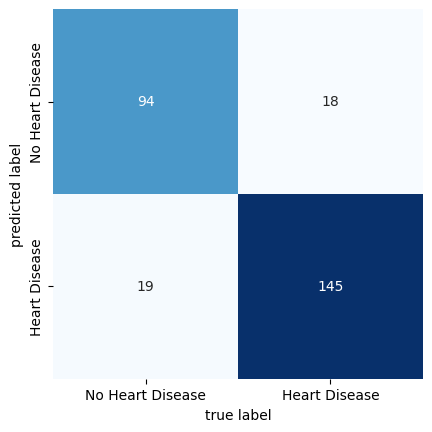

In [159]:
labels = ["No Heart Disease", "Heart Disease"]
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('true label')
plt.ylabel('predicted label')

### Model 6

Reset data after PCA

In [160]:
X = df.drop(['HeartDisease'], axis=1)
y = df['HeartDisease']
# Initialize Scaler
scaler = StandardScaler()

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
# Transform numerical columns
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
one = OneHotEncoder()
column_trans = make_column_transformer(
    (one,['Sex', 'ChestPainType','RestingECG', 'ExerciseAngina', 'ST_Slope']),  
    remainder='passthrough'
)
X = column_trans.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


The next model developed in an attempt to increase accuracy was a model which used cross validation to attempt to tune two additional hyperparameters:
1. **Weights:** This parameter controls whether distance of neighbours is taken into account. It can be either:
- Uniform: Here all neighbours have an equal weight regardless of distance.
- Distance: With this setting the weight of each neigbour is proportional to its distance.
2. **Metric:** This parameter specifies which distance metric is used to calculate distance between datapoints. Metrics which were included in gridsearch were:
- Euclidean: This is the distance between two data points calculated as a straight line between data points.
- Manhatten: This is distance between two points calculates as a "city block" distance. This means the length of two lines horizontal and vertical between the two points, not diagonally.
- Minkowski: Minkowski distances is a generalisation of both Euclidean and Manhatten distance.

In [161]:
parameters = {
     "n_neighbors": range(1, 50),
     "weights": ["uniform", "distance"],
     "metric": ["euclidean","manhattan","minkowski"]
}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train, y_train)
gridsearch.best_params_

{'metric': 'manhattan', 'n_neighbors': 12, 'weights': 'distance'}

Here we see while overall accuracy slightly decreased, the occurance of False negatives decreased with Model 6. Due to the fact that we are trying to predict whether a human has heart disease, minimisingthe occurence of False negatives as much as possible is very important. Therefore, although accuracy did decrease, in my opinion Model 6 is the best model to date due to it reducing False Negative occurences.

In [162]:
y_pred = gridsearch.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       113
           1       0.87      0.91      0.89       163

    accuracy                           0.86       276
   macro avg       0.86      0.85      0.86       276
weighted avg       0.86      0.86      0.86       276



Text(113.9222222222222, 0.5, 'predicted label')

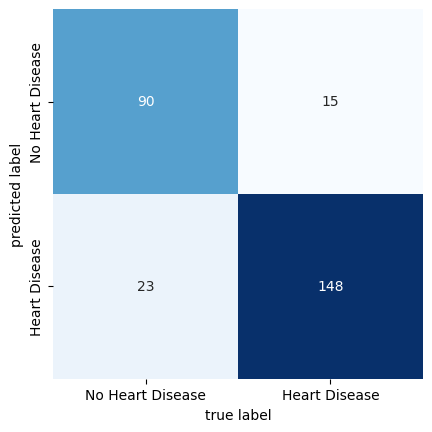

In [163]:
labels = ["No Heart Disease", "Heart Disease"]
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [164]:
from sklearn.ensemble import BaggingClassifier
bagging_model = BaggingClassifier(gridsearch, n_estimators=100)

In [165]:
bagging_model.fit(X_train, y_train)

BaggingClassifier(estimator=GridSearchCV(estimator=KNeighborsClassifier(),
                                         param_grid={'metric': ['euclidean',
                                                                'manhattan',
                                                                'minkowski'],
                                                     'n_neighbors': range(1, 50),
                                                     'weights': ['uniform',
                                                                 'distance']}),
                  n_estimators=100)

In [166]:
y_pred = bagging_model.predict(X_test)
y_pred

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1], dtype=int64)

Attempted to use a bagging classifier to increase performance with 100 estimators. While this did not achieve an increase in performace, the fact the accuracy result in close to Model 6 does show that this model is consistent across different slices of the training data.

In [167]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       113
           1       0.86      0.90      0.88       163

    accuracy                           0.86       276
   macro avg       0.85      0.84      0.85       276
weighted avg       0.85      0.86      0.85       276

